<h1><center>TEXT CLASSIFCATION USING BERT AND LSTM</center></h1>

In [1]:
#Import statements
import pandas as pd
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import BertTokenizer,BertModel
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

In [2]:
#Read the data
data=pd.read_csv("bbc-text.csv")

In [3]:
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
data["category"].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

<h2> Distribution of the data </h2>

<AxesSubplot: xlabel='category', ylabel='Count'>

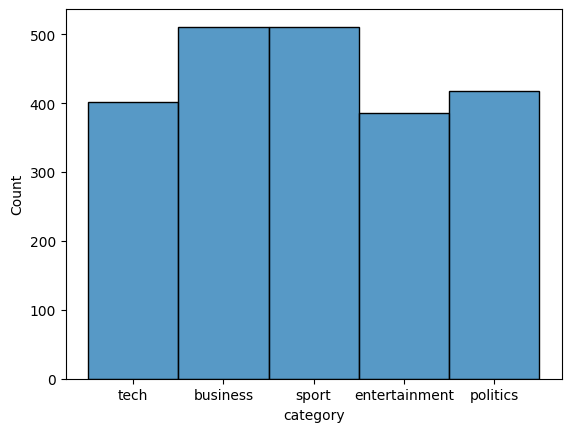

In [5]:
sns.histplot(data["category"])

<h2> Example of text </h2>

In [6]:
data["text"][0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

<h2> Format the data </h2>

<h3> Encode the labels </h3>

In [7]:
#Encode the labels
encode_dict= {
            "sport":0,
            "business":1,
            "politics":2,
            "tech":3,
            "entertainment":3
           }

In [8]:
X_data=data["text"]
Y_data=data["category"].map(encode_dict)

In [9]:
X_data.head()

0    tv future in the hands of viewers with home th...
1    worldcom boss  left books alone  former worldc...
2    tigers wary of farrell  gamble  leicester say ...
3    yeading face newcastle in fa cup premiership s...
4    ocean s twelve raids box office ocean s twelve...
Name: text, dtype: object

In [10]:
Y_data.head()

0    3
1    1
2    0
3    0
4    3
Name: category, dtype: int64

<h3> Split data into train and test </h3>

In [11]:
X_train, X_test,Y_train, Y_test = \
train_test_split(X_data,Y_data,test_size=0.2)

<h3> Further split train data into train and validation data </h3>

In [12]:
X_train, X_val,Y_train, Y_val = \
train_test_split(X_train,Y_train,test_size=0.2)

<h3> Data counts in each set </h3>

In [13]:
print("TRAINING DATA",len(X_train))
print("VALIDATION DATA",len(X_val))
print("TEST DATA",len(X_test))

TRAINING DATA 1424
VALIDATION DATA 356
TEST DATA 445


<h2> GET BERT EMBEDDINGS OF THE DATA </h2>
<h3> Use the hugging face transformer package to the BERT pretrained embeddings </h3>

In [ ]:
MAX_SEQ_LEN_BERT=512 #max length for bert

In [ ]:
def get_bert_embedding(text_list):
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',model_max_length=MAX_SEQ_LEN_BERT)
    bert_model = BertModel.from_pretrained('bert-base-uncased',
                                      output_hidden_states = True,
                                      )
    bert_model.eval()
    vec_list=[]
    for text in tqdm(text_list):
        with torch.no_grad():
            encoded_text = bert_tokenizer(text, return_tensors="pt",return_attention_mask=True,\
                                       return_token_type_ids=True,padding='max_length',truncation_strategy="longest_first")
            bert_embeding = bert_model(**encoded_text)
            vec_list.append(bert_embeding["last_hidden_state"])
    return torch.concat(vec_list, dim=0)

In [ ]:
#Get vectors of train data
X_train_vec=get_bert_embedding(X_train)

In [ ]:
#Get vectors of train data
X_test_vec=get_bert_embedding(X_test)
X_test_vec.shape

In [ ]:
#Get vectors of validation data
X_val_vec=get_bert_embedding(X_val)
X_val_vec.shape

<h2> BUILD THE PYTORCH MODEL </h2>


In [ ]:
EMBEDDING_DIM=768

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=EMBEDDING_DIM, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64,32,bias=True)
        self.d1 = nn.Dropout(p=0.2)
        self.fc2=nn.Linear(32,5,bias=True)
        
    def forward(self,inp):
        output,(hidden, cell) = self.lstm(inp)
        output=torch.squeeze(hidden)
        output=self.fc1(output)
        output=nn.functional.relu(output)
        output=self.d1(output)
        output=self.fc2(output)
        output=nn.functional.softmax(output)
        return output

In [ ]:
lstm_classifier = LSTMClassifier()
lstm_classifier

<h2> Create the data loader of given batch size </h2>

In [ ]:
BATCH_SIZE=16
dl = DataLoader(TensorDataset(X_train_vec,torch.tensor(Y_train.values)), batch_size=BATCH_SIZE)
LEN_DL = len(dl) #number of batches
EPOCHS=25

In [ ]:
#Set device here
device="cpu"

<h2> Create optimizier and loss function and set it to the appropiate device </h2>

In [ ]:
lstm_classifier = lstm_classifier.to(device)
optimizer = optim.Adam(lstm_classifier.parameters(),lr=1e-4)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:

for epoch in range(0,EPOCHS):
    epoch_loss=0
    epoch_accuracy=0
    print("EPOCH",epoch+1)
    for batch, (x,y) in enumerate(dl):
        x=x.to(device)
        out=lstm_classifier(x)
        y=y.to(device)
        optimizer.zero_grad()
        loss = criterion(out, y)
        acc=sum(out.detach().cpu().numpy().argmax(axis=1)==y.numpy())/BATCH_SIZE
        loss.backward()      
        optimizer.step()
        epoch_loss=epoch_loss+loss
        epoch_accuracy=epoch_accuracy+acc
        #endsep = "\n" if batch == LEN_DL -1 else "\r"
        endsep="\r"
        print (f"Batch :: {batch+1}/{LEN_DL} : Accuracy :: {acc} : loss :: {loss.detach().item()}", end=endsep, flush=True)
    print("Accuracy: ",epoch_accuracy/LEN_DL," loss: ",epoch_loss.item()/LEN_DL)
    with torch.no_grad():   
        val_out=lstm_classifier(X_val_vec)
        val_acc=sum(val_out.detach().cpu().numpy().argmax(axis=1)==Y_val.values)/len(Y_val)
        print("Validation Accuracy",val_acc)
        

<h2> TEST DATA EVALUATION <h2>

In [ ]:
y_pred=lstm_classifier(X_test_vec).detach().numpy().argmax(axis=1)

In [ ]:
print(classification_report(Y_test,y_pred))

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_test,y_pred)

<h2> TRY it OUT </h2>


In [ ]:
text="""
I believe in intensity, especially as it relates to sports. Without it, we can easily go through the motions—never really giving our full effort or going beyond what we think we can give. It has been said that a person will never be great without intensity, but I wouldn’t say that is always true. I have personally played with and seen many competitors who have gotten by with strictly using their God-given talents.

"""

In [ ]:
text_vec=get_bert_embedding([text])
text_pred=lstm_classifier(text_vec).detach().numpy().argmax(axis=0)
if text_pred==0:
    print("sport")
elif text_pred==1:
    print("business")
elif text_pred==2:
    print("politics")
elif text_pred==3:
    print("tech")
elif text_pred==4:
    print("entertainment")